##Proyek Akhir : Image Classification Model Deployment
Insyiraah Oxaichiko Arissinta

Mengembangkan model ML untuk klasifikasi gambar kemudian mengkonversi model tersebut ke dalam format berkas TF-Lite yang dapat di embed di Android dan iOS.

##Kriteria Submission
Berikut kriteria submission yang harus Anda penuhi:

1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 buah gambar.
2. Dataset dibagi menjadi 80% train set dan 20% test set.
3. Model harus menggunakan model sequential.
4. Model harus menggunakan Conv2D Maxpooling Layer.
5. Akurasi pada training dan validation set minimal sebesar 80%.
6. Menggunakan Callback.
7. Membuat plot terhadap akurasi dan loss model.
8. Menulis kode untuk menyimpan model ke dalam format TF-Lite.

Saran Submission:
1. Dataset yang digunakan berisi lebih dari 2000 gambar.
2. Mengimplementasikan Callback.
3. Gambar-gambar pada dataset memiliki resolusi yang tidak seragam.

Pada Submission ini saya akan menggunakan dataset animals yang saya peroleh dari https://www.kaggle.com/madisona/translated-animals10/version/1

##Instal Kaggle

In [1]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oxaichiko","key":"aaae30bc51761f8e13d8cc6a5557d15f"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


##Import Library

In [7]:
from io import BytesIO
from IPython.display import Image as IMG
from google.colab import files
from keras.preprocessing import image
from shutil import copyfile
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlopen
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import zipfile, os
import warnings

##Download Dataset

In [9]:
!kaggle datasets download -d madisona/translated-animals10

 97% 569M/586M [00:06<00:00, 79.2MB/s]
100% 586M/586M [00:06<00:00, 100MB/s] 


In [10]:
!mkdir animals
!unzip -qq translated-animals10.zip -d animals
!ls animals

animals10


##Memeriksa Dataset

In [11]:
animals = ['chicken', 'spider', 'sheep', 'butterfly', 'elephant', 'cat']

for animal in animals:
    print(f'{animal} images: ', len(os.listdir(f'/content/animals/animals10/raw-img/{animal}')))

chicken images:  3098
spider images:  4821
sheep images:  1820
butterfly images:  2112
elephant images:  1446
cat images:  1668


##Folder

In [12]:

try:
  os.mkdir('/content/animals/animals10/training')
  os.mkdir('/content/animals/animals10/testing')
  for animal in animals:
    os.mkdir(f'/content/animals/animals10/training/{animal}')
    os.mkdir(f'/content/animals/animals10/testing/{animal}')
except OSError:
  pass

##Split Dataset Menjadi Data Training dan Data Testing

In [13]:
def split_data(images_path, training_path, testing_path, split_size):
    files = []
    for filename in os.listdir(images_path):
        file = images_path + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " others")

    training_length = int(len(files) * split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = images_path + filename
        destination = training_path + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = images_path + filename
        destination = testing_path + filename
        copyfile(this_file, destination)
split_size = 0.8 # 80% Data Training and 20% Data Validation

chicken_images_path = "/content/animals/animals10/raw-img/chicken/"
chicken_train_path = "/content/animals/animals10/training/chicken/"
chicken_test_path = "/content/animals/animals10/testing/chicken/"
split_data(chicken_images_path, chicken_train_path, chicken_test_path, split_size)

spider_images_path = "/content/animals/animals10/raw-img/spider/"
spider_train_path = "/content/animals/animals10/training/spider/"
spider_test_path = "/content/animals/animals10/testing/spider/"
split_data(spider_images_path, spider_train_path, spider_test_path, split_size)

sheep_images_path = "/content/animals/animals10/raw-img/sheep/"
sheep_train_path = "/content/animals/animals10/training/sheep/"
sheep_test_path = "/content/animals/animals10/testing/sheep/"
split_data(sheep_images_path, sheep_train_path, sheep_test_path, split_size)

butterfly_images_path = "/content/animals/animals10/raw-img/butterfly/"
butterfly_train_path = "/content/animals/animals10/training/butterfly/"
butterfly_test_path = "/content/animals/animals10/testing/butterfly/"
split_data(butterfly_images_path, butterfly_train_path, butterfly_test_path, split_size)

elephant_images_path = "/content/animals/animals10/raw-img/elephant/"
elephant_train_path = "/content/animals/animals10/training/elephant/"
elephant_test_path = "/content/animals/animals10/testing/elephant/"
split_data(elephant_images_path, elephant_train_path, elephant_test_path, split_size)

cat_images_path = "/content/animals/animals10/raw-img/cat/"
cat_train_path = "/content/animals/animals10/training/cat/"
cat_test_path = "/content/animals/animals10/testing/cat/"
split_data(cat_images_path, cat_train_path, cat_test_path, split_size)




##Total Data Training dan Data Validation

In [14]:
total_train = len(os.listdir(chicken_train_path)) + len(os.listdir(spider_train_path)) + \
              len(os.listdir(sheep_train_path)) + len(os.listdir(butterfly_train_path)) + \
              len(os.listdir(elephant_train_path)) + len(os.listdir(cat_train_path))
total_test  = len(os.listdir(chicken_test_path)) + len(os.listdir(spider_test_path)) + \
              len(os.listdir(sheep_test_path)) + len(os.listdir(butterfly_test_path)) + \
              len(os.listdir(elephant_test_path)) + len(os.listdir(cat_test_path))

print("We have a total training data of " + str(total_train) + " rows and validation data of " + str(total_test))

We have a total training data of 11969 rows and validation data of 2996


#Modelling

##Augmentasi Gambar

In [15]:
TRAINING_DIR = '/content/animals/animals10/training'
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
) 

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, 
    batch_size = 64,
    class_mode = 'categorical',
    target_size = (150,150)
)

VALIDATION_DIR = "/content/animals/animals10/testing"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 64,
    class_mode = 'categorical',
    target_size = (150, 150)
)

Found 11969 images belonging to 6 classes.
Found 2996 images belonging to 6 classes.


##Callbacks
Agar running otomatis berhenti ketika mencapai akurasi maksimum

In [16]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

##Plot Function

In [17]:

plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

##Membangun Model CNN

In [18]:
tf.keras.backend.clear_session()

model_simple = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

##Running Model yang sudah dibangun

In [19]:
model_simple.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history_simple = model_simple.fit(
    train_generator,
    epochs=100,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=validation_generator
)

Epoch 1/100
188/188 [==============================] - 126s 503ms/step - loss: 1.5307 - accuracy: 0.3928 - val_loss: 1.5288 - val_accuracy: 0.4332
Epoch 2/100
188/188 [==============================] - 93s 495ms/step - loss: 1.2635 - accuracy: 0.5195 - val_loss: 1.2170 - val_accuracy: 0.5401
Epoch 3/100
188/188 [==============================] - 92s 489ms/step - loss: 1.1086 - accuracy: 0.5886 - val_loss: 0.9415 - val_accuracy: 0.6532
Epoch 4/100
188/188 [==============================] - 92s 491ms/step - loss: 1.0418 - accuracy: 0.6190 - val_loss: 0.9194 - val_accuracy: 0.6549
Epoch 5/100
188/188 [==============================] - 92s 490ms/step - loss: 0.9822 - accuracy: 0.6426 - val_loss: 0.9731 - val_accuracy: 0.6409
Epoch 6/100
188/188 [==============================] - 92s 492ms/step - loss: 0.9010 - accuracy: 0.6769 - val_loss: 0.7874 - val_accuracy: 0.7076
Epoch 7/100
188/188 [==============================] - 93s 493ms/step - loss: 0.8275 - accuracy: 0.6996 - val_loss: 0.8017 

##Visualisasi Plot Akurasi Training dan Validation 

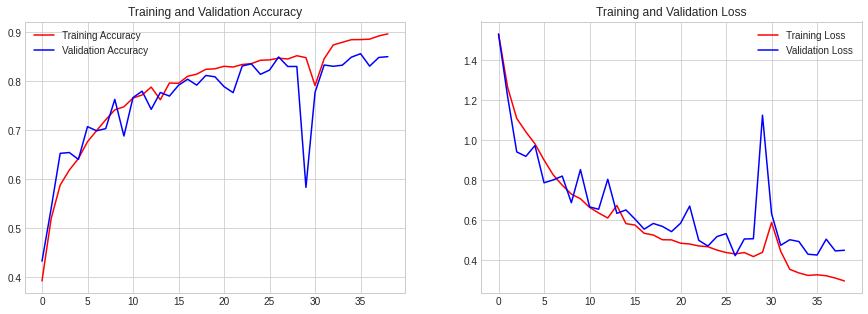

In [20]:
plot_history(history_simple)

##Evaluasi

In [21]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model_simple.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['chicken',
                'spider',
                'sheep',
                'butterfly',
                'elephant',
                'cat']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 2996 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[377   3  16   5   3  19]
 [  6 247  20  14  24  23]
 [  8  11 559  15  13  14]
 [  2   2   7 258  18   3]
 [  1   7  25  41 288   2]
 [ 89  11  24   9  15 817]]
Classification Report
              precision    recall  f1-score   support

     chicken       0.78      0.89      0.83       423
      spider       0.88      0.74      0.80       334
       sheep       0.86      0.90      0.88       620
   butterfly       0.75      0.89      0.82       290
    elephant       0.80      0.79      0.79       364
         cat       0.93      0.85      0.89       965

    accuracy                           0.85      2996
   macro avg       0.83      0.84      0.84      2996
weighted avg       0.86      0.85      0.85      2996



##Menyimpan Model ke Dalam Format TF-Lite

In [22]:
model_simple.save_weights('model_simple_weights.h5')
model_simple.save('model_simple.h5')

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_simple)
tflite_model_simple = converter.convert()

with tf.io.gfile.GFile('model_simple.tflite', 'wb') as f:
  f.write(tflite_model_simple)
  

INFO:tensorflow:Assets written to: /tmp/tmpvcj5uefk/assets


##Transfer Learning (InceptionV3)

In [24]:
tf.keras.backend.clear_session()

model_inception = tf.keras.models.Sequential([
    InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_inception.layers[0].trainable = False

model_inception.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1179712   
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 22,983,638
Trainable params: 1,180,854
Non-

##Running

In [25]:
model_inception.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

history_inception = model_inception.fit(
    train_generator,
    epochs=100,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=validation_generator
)

Epoch 1/100
188/188 [==============================] - 100s 511ms/step - loss: 0.7147 - accuracy: 0.7764 - val_loss: 0.2364 - val_accuracy: 0.9443
Epoch 2/100
188/188 [==============================] - 91s 485ms/step - loss: 0.3571 - accuracy: 0.9027 - val_loss: 0.1803 - val_accuracy: 0.9566
Epoch 3/100
188/188 [==============================] - 91s 484ms/step - loss: 0.3329 - accuracy: 0.9041 - val_loss: 0.1618 - val_accuracy: 0.9586
Epoch 4/100
188/188 [==============================] - 92s 491ms/step - loss: 0.2886 - accuracy: 0.9151 - val_loss: 0.1697 - val_accuracy: 0.9439
Epoch 5/100
188/188 [==============================] - 91s 484ms/step - loss: 0.2695 - accuracy: 0.9195 - val_loss: 0.1369 - val_accuracy: 0.9596
Epoch 6/100
188/188 [==============================] - 93s 497ms/step - loss: 0.2361 - accuracy: 0.9271 - val_loss: 0.1267 - val_accuracy: 0.9660
Epoch 7/100
188/188 [==============================] - 93s 496ms/step - loss: 0.2234 - accuracy: 0.9317 - val_loss: 0.1191 

##Visualisasi Plot Akurasi Training and Validation

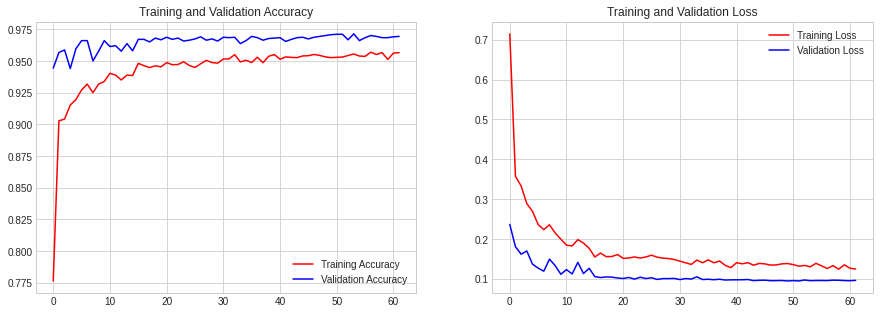

In [26]:
plot_history(history_inception)

##Evaluasi

In [27]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model_inception.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['chicken',
                'spider',
                'sheep',
                'butterfly',
                'elephant',
                'cat']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 2996 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[399   3   5   0   1  15]
 [  3 323   1   0   7   0]
 [  3   0 606   0   6   5]
 [  1   1   1 282   5   0]
 [  0   2   5  11 346   0]
 [ 10   1   2   0   0 952]]
Classification Report
              precision    recall  f1-score   support

     chicken       0.96      0.94      0.95       423
      spider       0.98      0.97      0.97       334
       sheep       0.98      0.98      0.98       620
   butterfly       0.96      0.97      0.97       290
    elephant       0.95      0.95      0.95       364
         cat       0.98      0.99      0.98       965

    accuracy                           0.97      2996
   macro avg       0.97      0.97      0.97      2996
weighted avg       0.97      0.97      0.97      2996



##Menyimpan Model ke Dalam Format TF-Lite.

In [28]:
model_inception.save_weights('model_inception_weights.h5')
model_inception.save('model_inception.h5')

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_inception)
tflite_model_inception = converter.convert()

with tf.io.gfile.GFile('model_inception.tflite', 'wb') as f:
  f.write(tflite_model_inception)

INFO:tensorflow:Assets written to: /tmp/tmpix56ku1u/assets


INFO:tensorflow:Assets written to: /tmp/tmpix56ku1u/assets


##Memprediksi

In [30]:
def predict_image(image_upload, model = model_inception):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['butterfly',
          'cat',
          'chicken',
          'elephant',
          'sheep',
          'spider']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Butterfly'
  elif predict_label == 1:
      predict_product = 'Cat'
  elif predict_label == 2:
      predict_product = 'Chicken'
  elif predict_label == 3:
      predict_product = 'Elephant'
  elif predict_label == 4:
      predict_product = 'Sheep'
  else:
      predict_product = 'Spider'

  return predict_product, df






##Memprediksi Gambar

In [31]:
def predict():
  uploaded = files.upload()

  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img = np.vstack([x])

  label, df = predict_image(img)

  print('\n')
  plt.show()
  print("\nThe image is detected as " + label)
  print('\n')
  print(df)
  print('\n')

Saving 005940800_1552970791-fotoHL_kucing.jpg to 005940800_1552970791-fotoHL_kucing.jpg




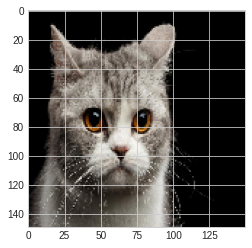


The image is detected as Cat


     Product  Probability
0  butterfly     0.000045
1        cat     0.999881
2    chicken     0.000002
3   elephant     0.000036
4      sheep     0.000008
5     spider     0.000028




In [32]:
predict()

Saving download (3).jpg to download (3).jpg




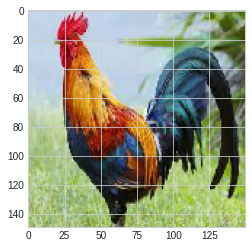


The image is detected as Chicken


     Product  Probability
0  butterfly     0.000001
1        cat     0.000017
2    chicken     0.999934
3   elephant     0.000002
4      sheep     0.000044
5     spider     0.000002




In [33]:
predict()

Saving download (4).jpg to download (4).jpg




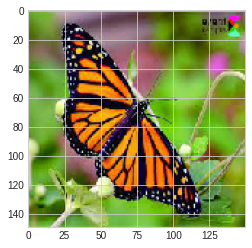


The image is detected as Butterfly


     Product   Probability
0  butterfly  9.999996e-01
1        cat  1.420664e-09
2    chicken  3.018048e-07
3   elephant  6.830557e-10
4      sheep  1.324352e-08
5     spider  4.403019e-10




In [34]:
predict()

Saving download (5).jpg to download (5).jpg




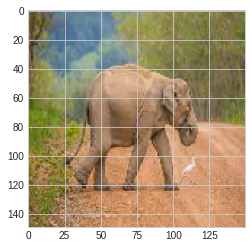


The image is detected as Elephant


     Product   Probability
0  butterfly  4.587185e-07
1        cat  1.464597e-07
2    chicken  2.338779e-07
3   elephant  9.999709e-01
4      sheep  2.659040e-05
5     spider  1.663061e-06




In [35]:
predict()

Saving download (6).jpg to download (6).jpg




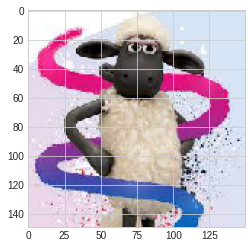


The image is detected as Sheep


     Product  Probability
0  butterfly     0.008570
1        cat     0.017511
2    chicken     0.078378
3   elephant     0.126668
4      sheep     0.756905
5     spider     0.011968




In [36]:
predict()

Saving download (7).jpg to download (7).jpg




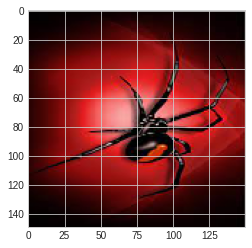


The image is detected as Spider


     Product   Probability
0  butterfly  1.710016e-05
1        cat  1.157554e-08
2    chicken  1.296314e-06
3   elephant  4.287663e-09
4      sheep  2.950927e-08
5     spider  9.999816e-01




In [37]:
predict()

Hasil prediksi model berhasil mengklasifikasikan gambar dengan tepat